# Twitch Growth and Advertising Partnership Analysis

## Business Understanding

## Stakeholder: Companies that wish to advertise on Twitch and develop long term relationships with livestreamers

## Task: Identify livestreamers that have had a significant increase in growth and predict if they will continue to do so


Many companies currently use Twitch influencer marketing to advertise directly on the livestream, turning the livestreamer's content into the advertisement. With this type of promotion it's very important for advertisers to be able to correctly identify promising streamers that will continue to bring a large audience to see their product.

To read more about Twitch Influencer Marketing read here:
https://influencermarketinghub.com/twitch-marketing/

Load Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, plot_confusion_matrix, plot_roc_curve
from sklearn.tree import plot_tree
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

## Loading Data and Inital Analysis

Dataset curated from Twitch's API, you'll need to get your own api key: https://dev.twitch.tv/docs/api/

https://www.kaggle.com/aayushmishra1512/twitchdata

https://www.kaggle.com/girlazo/top-8800-twitch-streamers

One dataset is from the last year and the other is from 4 years ago. We need this time disparity in order to gauge just how much these livestreamers are growing by. There are some limitations of the data that you can get off of Twitch's API though. I cannot for example pull the average watch time of the viewers, if the stream was muted, or other points of interest. This means I will not be able to filter out channels that people watch to fall asleep to where the viewer may be less engaged and therefore less interesting to advertisers.

In [2]:
df = pd.read_csv('data/twitchdata-update.csv')
df_extended = pd.read_csv('data/TwitchDataSet.csv')
df.head()

,Channel,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Followers gained,Views gained,Partnered,Mature,Language
0,xQcOW,6196161750,215250,222720,27716,3246298,1734810,93036735,True,False,English
1,summit1g,6091677300,211845,310998,25610,5310163,1370184,89705964,True,False,English
2,Gaules,5644590915,515280,387315,10976,1767635,1023779,102611607,True,True,Portuguese
3,ESL_CSGO,3970318140,517740,300575,7714,3944850,703986,106546942,True,False,English
4,Tfue,3671000070,123660,285644,29602,8938903,2068424,78998587,True,False,English


This is the dataset from last year of the top 1000 livestreamers on twitch based on their views

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Channel               1000 non-null   object
 1   Watch time(Minutes)   1000 non-null   int64 
 2   Stream time(minutes)  1000 non-null   int64 
 3   Peak viewers          1000 non-null   int64 
 4   Average viewers       1000 non-null   int64 
 5   Followers             1000 non-null   int64 
 6   Followers gained      1000 non-null   int64 
 7   Views gained          1000 non-null   int64 
 8   Partnered             1000 non-null   bool  
 9   Mature                1000 non-null   bool  
 10  Language              1000 non-null   object
dtypes: bool(2), int64(7), object(2)
memory usage: 72.4+ KB


#### Check For Null Values

In [4]:
df.isnull().sum()

Channel                 0
Watch time(Minutes)     0
Stream time(minutes)    0
Peak viewers            0
Average viewers         0
Followers               0
Followers gained        0
Views gained            0
Partnered               0
Mature                  0
Language                0
dtype: int64

#### checking column datatypes

In [5]:
df.dtypes

Channel                 object
Watch time(Minutes)      int64
Stream time(minutes)     int64
Peak viewers             int64
Average viewers          int64
Followers                int64
Followers gained         int64
Views gained             int64
Partnered                 bool
Mature                    bool
Language                object
dtype: object

In [6]:
df.describe()

,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Followers gained,Views gained
count,1.000000e+03,1000.000000,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1.000000e+03
mean,4.184279e+08,120515.160000,37065.051000,4781.040000,5.700541e+05,2.055185e+05,1.166817e+07
std,5.496355e+08,85376.201364,60314.307686,8453.684965,8.044134e+05,3.399137e+05,2.490572e+07
min,1.221928e+08,3465.000000,496.000000,235.000000,3.660000e+03,-1.577200e+04,1.757880e+05
25%,1.631899e+08,73758.750000,9113.750000,1457.750000,1.705462e+05,4.375825e+04,3.880602e+06
50%,2.349908e+08,108240.000000,16676.000000,2425.000000,3.180630e+05,9.835200e+04,6.456324e+06
75%,4.337399e+08,141843.750000,37569.750000,4786.250000,6.243322e+05,2.361308e+05,1.219676e+07
max,6.196162e+09,521445.000000,639375.000000,147643.000000,8.938903e+06,3.966525e+06,6.701375e+08


Exploring how many streamers mark their content as Mature

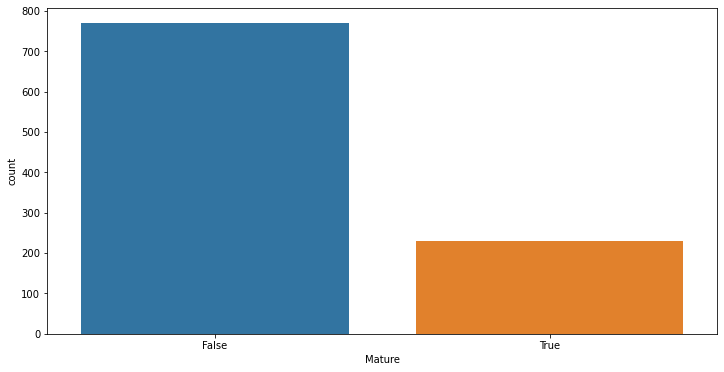

In [7]:
plt.figure(figsize=(12, 6))
plot = sns.countplot(x="Mature", data=df,order=df['Mature'].value_counts().index)

As you can see most top livestreamers on the platform do not mark their content as mature, most likely since their content appeals to all ages it is much easier for them to gain a significantly large audience

Exploring how many views were gained for each channel, plot is organized by largest streamer on the left to smallest streamer on the right

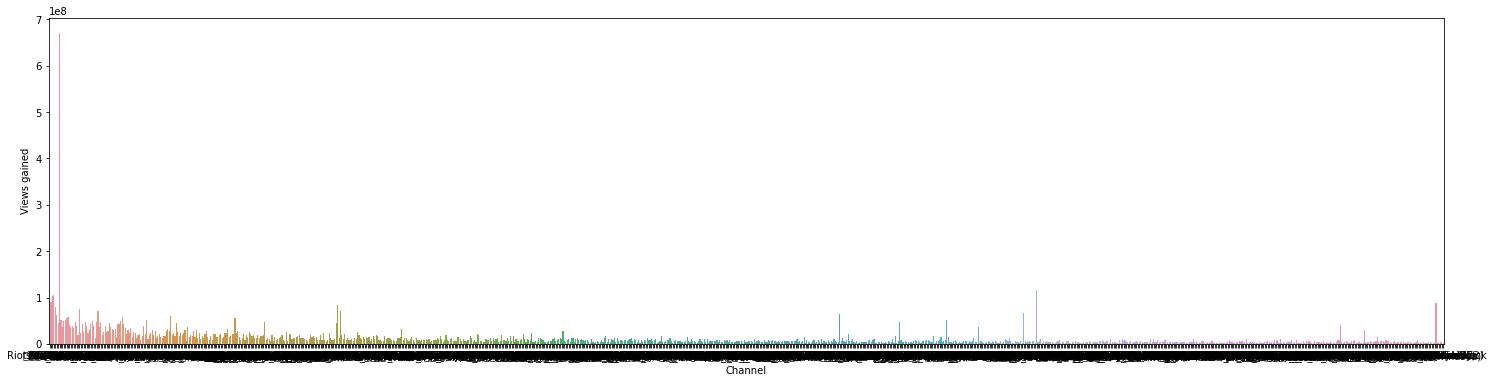

In [8]:
plt.figure(figsize=(25,6))
sns.barplot(x=df[df.Partnered == True]['Channel'], y=df[df.Partnered == True]['Views gained'],order=df[df.Partnered == True]['Channel'])
plt.show()

Since the data is organized by top streamer to smallest streamer we would expect the views gained to be larger on the left side (which it does) but it's not a completely linear relationship since some livestreamers experience a more explosive growth than others, this is what we want to be able to identify.

Exploring what languages are spoken by the top streamers

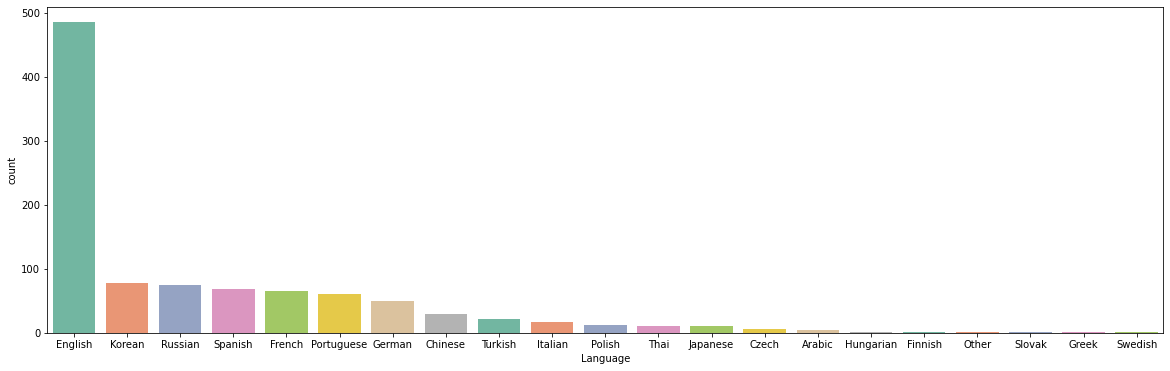

In [81]:
plt.figure(figsize=(20, 6))
plot = sns.countplot(x="Language", data=df,order=df['Language'].value_counts().index, palette="Set2")

This graph shows that most of the livestreamers that are on the top of the leaderboard do stream in English. However if you take a look at the top views ever on Twitch you can see that the vast majority of streamers stream in Spanish. (source: https://twitchtracker.com/channels/peak-viewers) this is something to look into when it comes to predicting whether or not a certain streamer will have explosive growth

Exploring views gained by streamers that aren't partnered

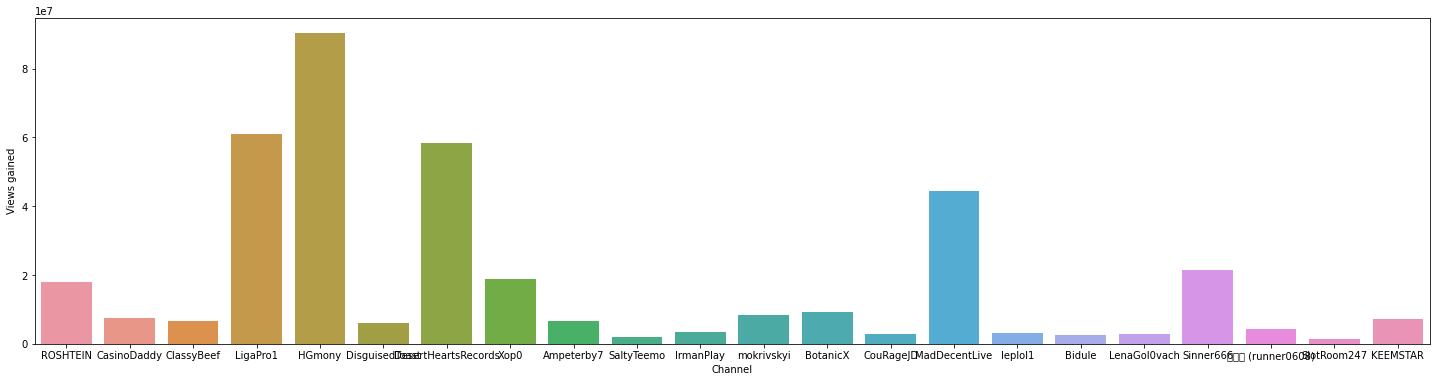

In [10]:
plt.figure(figsize=(25,6))
sns.barplot(x=df[df.Partnered == False]['Channel'] , y=df[df.Partnered == False]['Views gained'],order=df[df.Partnered == False]['Channel'])
plt.show()

There aren't a lot of livestreamers that aren't partnered that are among the top of the top livestreamers. Chances are we won't be able to make that many predictions on channels that aren't partnered.

Exploring views gained by channels that are not marked as mature

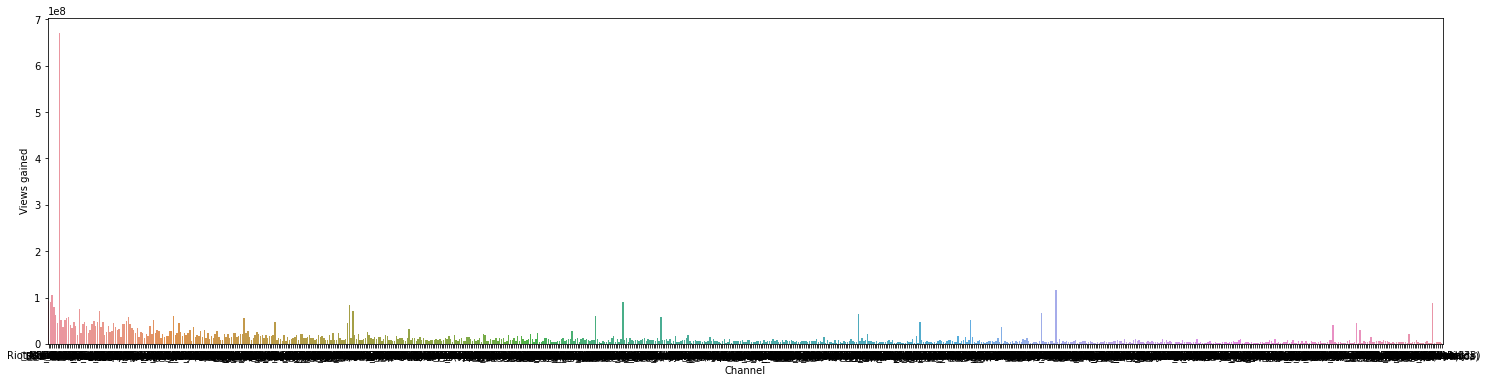

In [11]:
plt.figure(figsize=(25,6))
sns.barplot(x=df[df.Mature == False]['Channel'] , y=df[df.Mature == False]['Views gained'],order=df[df.Mature == False]['Channel'])
plt.show()

Exploring views gained by channels that are marked as mature

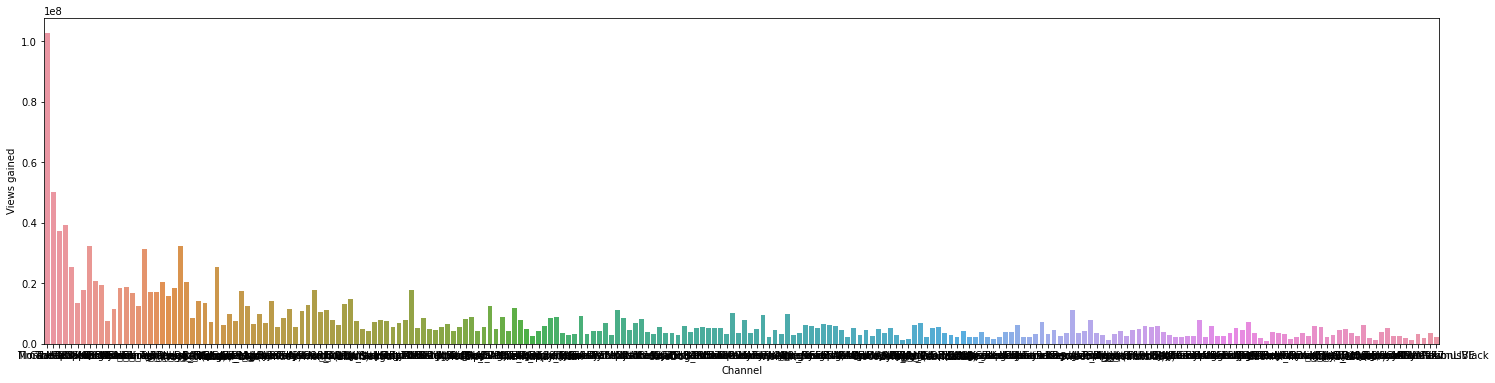

In [12]:
plt.figure(figsize=(25,6))
sns.barplot(x=df[df.Mature == True]['Channel'], y=df[df.Mature == True]['Views gained'],order=df[df.Mature == True]['Channel'])
plt.show()

When you compare the past two graphs, streams that aren't marked as mature gain significantly more views than the ones that are marked as mature.

Taking a look at the older database, this database has the top 8800 livestreamers from 4 years ago

In [13]:
df_extended.head()

,profile picture,top count,screen name,watch time,stream time,peak viewers,average viewers,followers,followers gained,views gained,partnered,mature,language,completa name,first category,second category,third category
0,https://static-cdn.jtvnw.net/jtv_user_pictures...,1,xQcOW,7333609065,215670,222720,32913,3691010,2051895,109735389,True,False,English,xQcOW,Just Chatting,Among Us,Overwatch
1,https://static-cdn.jtvnw.net/jtv_user_pictures...,2,Gaules,6314532585,515595,387315,12254,1966465,1141123,112807468,True,True,Portuguese,Gaules,Counter-Strike: Global Offensive,Among Us,PLAYERUNKNOWN
2,https://static-cdn.jtvnw.net/jtv_user_pictures...,3,summit1g,6235007490,216000,310998,25931,5374710,1402547,91501875,True,False,English,summit1g,Escape From Tarkov,Sea of Thieves,Grand Theft Auto V
3,https://static-cdn.jtvnw.net/jtv_user_pictures...,4,ESL_CSGO,4764929775,517965,300575,9249,4195657,870484,126008641,True,False,English,ESL_CSGO,Counter-Strike: Global Offensive,NaN,NaN
4,https://static-cdn.jtvnw.net/jtv_user_pictures...,5,NICKMERCS,3853252845,131880,163241,29183,4415637,1337535,49164651,True,False,English,NICKMERCS,Call Of Duty: Modern Warfare,Fortnite,Halo: The Master Chief Collection


In [14]:
df_extended.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8800 entries, 0 to 8799
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   profile picture   8800 non-null   object
 1   top count         8800 non-null   int64 
 2   screen name       8800 non-null   object
 3   watch time        8800 non-null   int64 
 4   stream time       8800 non-null   int64 
 5   peak viewers      8800 non-null   int64 
 6   average viewers   8800 non-null   int64 
 7   followers         8800 non-null   int64 
 8   followers gained  8800 non-null   int64 
 9   views gained      8800 non-null   int64 
 10  partnered         8800 non-null   bool  
 11  mature            8800 non-null   bool  
 12  language          8799 non-null   object
 13  completa name     8800 non-null   object
 14  first category    8795 non-null   object
 15  second category   8390 non-null   object
 16  third category    8009 non-null   object
dtypes: bool(2), in

In [15]:
df_extended.isnull().sum()

profile picture       0
top count             0
screen name           0
watch time            0
stream time           0
peak viewers          0
average viewers       0
followers             0
followers gained      0
views gained          0
partnered             0
mature                0
language              1
completa name         0
first category        5
second category     410
third category      791
dtype: int64

In [16]:
df_extended.dtypes

profile picture     object
top count            int64
screen name         object
watch time           int64
stream time          int64
peak viewers         int64
average viewers      int64
followers            int64
followers gained     int64
views gained         int64
partnered             bool
mature                bool
language            object
completa name       object
first category      object
second category     object
third category      object
dtype: object

## Data Merging and Cleaning

Merging the data sets together and drop duplicates, here are the steps:

First we merge the old and new datasets together by their channel name, whether or not they are partnered, their maturity setting (if this changed between the datasets that is motivation to remove the column), and the language they speak on stream

Next we drop any null values that we cannot simply replace

then we drop the following columns:

'first category' - The one hot encoder doesn't know what to do with this

'second category' - we'd have to drop a ton of streamers since we don't have data for this on a lot of streamers

'third category' - we'd have to drop a ton of streamers since we don't have data for this on a lot of streamers

'completa name' - This is the same as channel name

'Channel' - The channel name isn't useful for the prediction

'Language' - OHE doesn't know what to do with this

'profile picture' - This isn't going to help us predict anything, we aren't doing image recognition

'index' - this is not a categorical variable it's just the index in the dataset

In [17]:
##renaming columns so it matches the new database

df_extended.rename(columns={'screen name':'Channel', 'watch time': 'Watch time(Minutes)', 'stream time': 'Stream time(minutes)', 'peak viewers': 'Peak viewers', 'average viewers': 'Average viewers', 'followers': 'Followers', 'followers gained': 'Followers gained', 'views gained': 'Views gained', 'partnered': 'Partnered', 'mature': 'Mature', 'language': 'Language'}, inplace = True)

In [18]:
df_extended.head()

,profile picture,top count,Channel,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Followers gained,Views gained,Partnered,Mature,Language,completa name,first category,second category,third category
0,https://static-cdn.jtvnw.net/jtv_user_pictures...,1,xQcOW,7333609065,215670,222720,32913,3691010,2051895,109735389,True,False,English,xQcOW,Just Chatting,Among Us,Overwatch
1,https://static-cdn.jtvnw.net/jtv_user_pictures...,2,Gaules,6314532585,515595,387315,12254,1966465,1141123,112807468,True,True,Portuguese,Gaules,Counter-Strike: Global Offensive,Among Us,PLAYERUNKNOWN
2,https://static-cdn.jtvnw.net/jtv_user_pictures...,3,summit1g,6235007490,216000,310998,25931,5374710,1402547,91501875,True,False,English,summit1g,Escape From Tarkov,Sea of Thieves,Grand Theft Auto V
3,https://static-cdn.jtvnw.net/jtv_user_pictures...,4,ESL_CSGO,4764929775,517965,300575,9249,4195657,870484,126008641,True,False,English,ESL_CSGO,Counter-Strike: Global Offensive,NaN,NaN
4,https://static-cdn.jtvnw.net/jtv_user_pictures...,5,NICKMERCS,3853252845,131880,163241,29183,4415637,1337535,49164651,True,False,English,NICKMERCS,Call Of Duty: Modern Warfare,Fortnite,Halo: The Master Chief Collection


In [19]:
#Merging Datasets on the Channel, Partnered, Mature, and Language Columns
df_merge = pd.merge(df, df_extended, on=['Channel',
                                        'Partnered','Mature', 'Language']).reset_index()

#dropping duplicates(checks Channel for uniqueness)
df_dropped= df_merge.drop_duplicates(subset=['Channel'], keep='first')

In [20]:
df_dropped.head()

,index,Channel,Watch time(Minutes)_x,Stream time(minutes)_x,Peak viewers_x,Average viewers_x,Followers_x,Followers gained_x,Views gained_x,Partnered,...,Stream time(minutes)_y,Peak viewers_y,Average viewers_y,Followers_y,Followers gained_y,Views gained_y,completa name,first category,second category,third category
0,0,xQcOW,6196161750,215250,222720,27716,3246298,1734810,93036735,True,...,215670,222720,32913,3691010,2051895,109735389,xQcOW,Just Chatting,Among Us,Overwatch
1,1,summit1g,6091677300,211845,310998,25610,5310163,1370184,89705964,True,...,216000,310998,25931,5374710,1402547,91501875,summit1g,Escape From Tarkov,Sea of Thieves,Grand Theft Auto V
2,2,Gaules,5644590915,515280,387315,10976,1767635,1023779,102611607,True,...,515595,387315,12254,1966465,1141123,112807468,Gaules,Counter-Strike: Global Offensive,Among Us,PLAYERUNKNOWN
3,3,ESL_CSGO,3970318140,517740,300575,7714,3944850,703986,106546942,True,...,517965,300575,9249,4195657,870484,126008641,ESL_CSGO,Counter-Strike: Global Offensive,NaN,NaN
4,4,Tfue,3671000070,123660,285644,29602,8938903,2068424,78998587,True,...,130680,190173,25269,9184421,2023733,70427346,Tfue,Fortnite,Call Of Duty: Modern Warfare,Among Us


Anything denoted by an x is data from 4 years ago, anything by y is one year ago

In [21]:
df.size

11000

#### Checking For Null Values

In [23]:
df_dropped.isnull().sum()

index                      0
Channel                    0
Watch time(Minutes)_x      0
Stream time(minutes)_x     0
Peak viewers_x             0
Average viewers_x          0
Followers_x                0
Followers gained_x         0
Views gained_x             0
Partnered                  0
Mature                     0
Language                   0
profile picture            0
top count                  0
Watch time(Minutes)_y      0
Stream time(minutes)_y     0
Peak viewers_y             0
Average viewers_y          0
Followers_y                0
Followers gained_y         0
Views gained_y             0
completa name              0
first category             0
second category           50
third category            80
dtype: int64

### Dropping These Columns:

'first category' - The one hot encoder doesn't know what to do with this

'second category' - we'd have to drop a ton of streamers since we don't have data for this on a lot of streamers

'third category' - we'd have to drop a ton of streamers since we don't have data for this on a lot of streamers

'completa name' - This is the same as channel name

'Channel' - The channel name isn't useful for the prediction

'Language' - OHE doesn't know what to do with this

'profile picture' - This isn't going to help us predict anything, we aren't doing image recognition

'index' - this is not a categorical variable it's just the index in the dataset

In [24]:
df_dropped = df_dropped.drop(['first category','second category','third category','completa name', 'Channel', 'Language', 'profile picture', 'index'],axis=1)
#df_dropped = df_dropped.drop('third category',axis=1)

Most livestreamers hardly ever stream a second or third category and if they do it takes up a miniscule percentage of their total stream time

In [25]:
df_dropped.isnull().sum()

Watch time(Minutes)_x     0
Stream time(minutes)_x    0
Peak viewers_x            0
Average viewers_x         0
Followers_x               0
Followers gained_x        0
Views gained_x            0
Partnered                 0
Mature                    0
top count                 0
Watch time(Minutes)_y     0
Stream time(minutes)_y    0
Peak viewers_y            0
Average viewers_y         0
Followers_y               0
Followers gained_y        0
Views gained_y            0
dtype: int64

## Making a column that keeps track of whether or not there was increased growth between previous years

Anything denoted by an x is data from 4 years ago, anything by y is one year ago, we'll step through the average viewers for the previous year versus the newer year to decide whether or not there has been growth

In [26]:
old_growth = []
for index in df_dropped['Average viewers_x']:
    old_growth.append(index)

In [27]:
new_growth = []
for index in df_dropped['Average viewers_y']:
    new_growth.append(index)


In [28]:
positive_growth = []
for x in range(len(new_growth)):
    if new_growth[x] > old_growth[x]:
        positive_growth.append(True)
    else:
        positive_growth.append(False)

In [29]:
df_dropped.insert(2,'Increased_Growth', positive_growth)
df_dropped.head()

,Watch time(Minutes)_x,Stream time(minutes)_x,Increased_Growth,Peak viewers_x,Average viewers_x,Followers_x,Followers gained_x,Views gained_x,Partnered,Mature,top count,Watch time(Minutes)_y,Stream time(minutes)_y,Peak viewers_y,Average viewers_y,Followers_y,Followers gained_y,Views gained_y
0,6196161750,215250,True,222720,27716,3246298,1734810,93036735,True,False,1,7333609065,215670,222720,32913,3691010,2051895,109735389
1,6091677300,211845,True,310998,25610,5310163,1370184,89705964,True,False,3,6235007490,216000,310998,25931,5374710,1402547,91501875
2,5644590915,515280,True,387315,10976,1767635,1023779,102611607,True,True,2,6314532585,515595,387315,12254,1966465,1141123,112807468
3,3970318140,517740,True,300575,7714,3944850,703986,106546942,True,False,4,4764929775,517965,300575,9249,4195657,870484,126008641
4,3671000070,123660,False,285644,29602,8938903,2068424,78998587,True,False,9,3276339360,130680,190173,25269,9184421,2023733,70427346


## Data Preperation

Store the features in a variable names 'X' and the target variable 'Increased_Growth' in 'y'.

In [30]:
X = df_dropped.drop(['Increased_Growth','Average viewers_x', 'Average viewers_y'],axis=1)
y = df_dropped.Increased_Growth

In [31]:
X

,Watch time(Minutes)_x,Stream time(minutes)_x,Peak viewers_x,Followers_x,Followers gained_x,Views gained_x,Partnered,Mature,top count,Watch time(Minutes)_y,Stream time(minutes)_y,Peak viewers_y,Followers_y,Followers gained_y,Views gained_y
0,6196161750,215250,222720,3246298,1734810,93036735,True,False,1,7333609065,215670,222720,3691010,2051895,109735389
1,6091677300,211845,310998,5310163,1370184,89705964,True,False,3,6235007490,216000,310998,5374710,1402547,91501875
2,5644590915,515280,387315,1767635,1023779,102611607,True,True,2,6314532585,515595,387315,1966465,1141123,112807468
3,3970318140,517740,300575,3944850,703986,106546942,True,False,4,4764929775,517965,300575,4195657,870484,126008641
4,3671000070,123660,285644,8938903,2068424,78998587,True,False,9,3276339360,130680,190173,9184421,2023733,70427346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,122628630,103020,14566,48007,8995,87603521,True,False,1171,112819800,114090,14566,48735,8146,85061422
952,122524635,13560,21359,601927,562691,2162107,True,False,559,233955885,28215,21359,815833,797857,4145737
953,122523705,153000,3940,213212,52289,4399897,True,False,1029,127993785,150495,4460,228210,56879,4851825
954,122452320,217410,6431,109068,-4942,3417970,True,False,1179,111773565,224880,6431,106932,-7826,3213147


## Train-Test Split

Split the data into training and testing sets.

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

We now have a working dataset of: 'X_train' and 'y_train' to fit models to, 'X_test' to generate predictions, and 'y_test' to validate models with.

We use Increased_Growth as our target variable since we want to be able to predict whether or not a streamer is experiencing explosive growth, this means we want to see that the streamer is growing exponentially

### One Hot Encoding

Create binary columns for all values in categorical columns.

In [33]:
#Ohe-ing Train set
X_train_cat = X_train.select_dtypes('object')

ohe = OneHotEncoder(drop='first',sparse=False)

dums_train = ohe.fit_transform(X_train_cat)
dums_train_df = pd.DataFrame(dums_train,
                       columns=ohe.get_feature_names(),
                       index=X_train_cat.index)

nums_train_df = X_train.select_dtypes(['int64','float64'])

X_train_clean = pd.concat([nums_train_df, dums_train_df], axis=1)

In [34]:
#Ohe-ing Test set
X_test_cat = X_test.select_dtypes('object')

dums_test = ohe.transform(X_test_cat)
dums_test_df = pd.DataFrame(dums_test,
                       columns=ohe.get_feature_names(),
                       index=X_test_cat.index)

nums_test_df = X_test.select_dtypes(['int64','float64'])

X_test_clean = pd.concat([nums_test_df, dums_test_df], axis=1)

## Modeling

### Baseline Model

Baseline model for comparison

In [35]:
dummy = DummyClassifier(random_state=42) 

#establishing random_state for reproducibility
dummy.fit(X_train_clean, y_train)
y_pred = dummy.predict(X_test_clean)

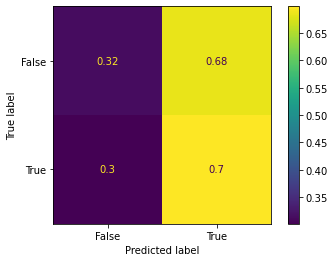

In [36]:
plot_confusion_matrix(estimator=dummy, X=X_test_clean, y_true=y_test, normalize='true');

In [37]:
y_train.value_counts(normalize=True)

True     0.670851
False    0.329149
Name: Increased_Growth, dtype: float64

In [38]:
print("Accuracy Score: {}".format(accuracy_score(y_test, y_pred)))

Accuracy Score: 0.5815899581589958


We want to beat this accuracy score as we iterate through different models

## Decision Tree

In [39]:
tree = DecisionTreeClassifier()

In [40]:
tree_grid = {'max_leaf_nodes': [4, 5, 6, 7], 
             'min_samples_split': [2, 3, 4],
             'max_depth': [2, 3, 4, 5],
            }

In [41]:
tree_grid_search = GridSearchCV(tree, tree_grid, cv=5)

In [42]:
tree_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 3, 4, 5],
                         'max_leaf_nodes': [4, 5, 6, 7],
                         'min_samples_split': [2, 3, 4]})

#### Best Parameters for Decision Tree model

In [43]:
tree_grid_search.best_params_

{'max_depth': 2, 'max_leaf_nodes': 4, 'min_samples_split': 2}

#### Best scores for Decision Tree model

In [44]:
tree_grid_search.best_score_

0.6917249417249417

In [45]:
tree_grid_search.best_estimator_.score(X_test, y_test)

0.6820083682008368

In [46]:
best_tree = tree_grid_search.best_estimator_

In [47]:
tree_test_preds = best_tree.predict(X_test)

[Text(334.8, 543.6, 'X[13] <= 43604.0\ngini = 0.442\nsamples = 717\nvalue = [236, 481]'),
 Text(167.4, 326.16, 'X[4] <= 40694.5\ngini = 0.499\nsamples = 192\nvalue = [100, 92]'),
 Text(83.7, 108.72000000000003, 'gini = 0.494\nsamples = 160\nvalue = [71, 89]'),
 Text(251.10000000000002, 108.72000000000003, 'gini = 0.17\nsamples = 32\nvalue = [29, 3]'),
 Text(502.20000000000005, 326.16, 'X[1] <= 30555.0\ngini = 0.384\nsamples = 525\nvalue = [136, 389]'),
 Text(418.5, 108.72000000000003, 'gini = 0.494\nsamples = 38\nvalue = [21, 17]'),
 Text(585.9, 108.72000000000003, 'gini = 0.361\nsamples = 487\nvalue = [115, 372]')]

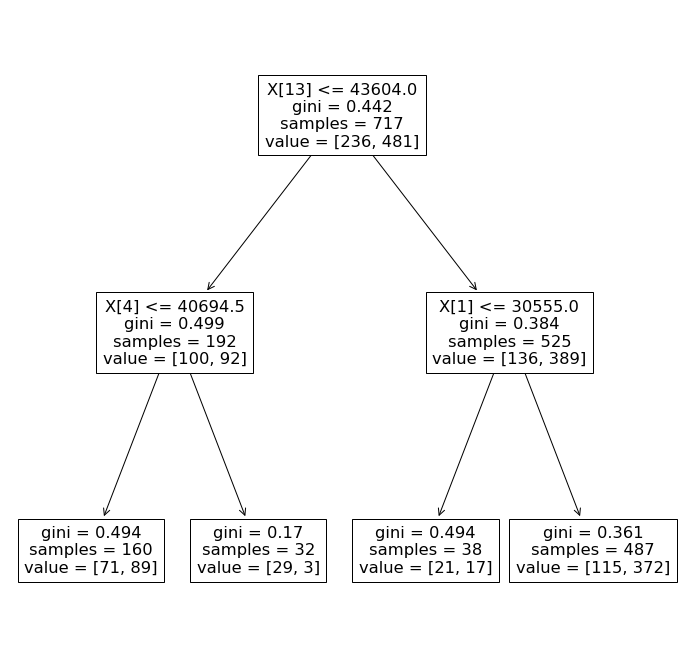

In [75]:
#creating a visualization of the decision tree
plt.figure(figsize=(12,12))
plot_tree(best_tree)

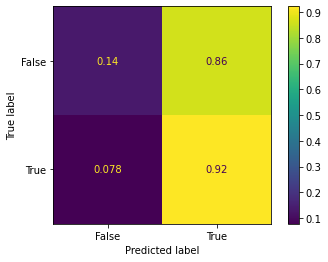

In [49]:
plot_confusion_matrix(best_tree, X_test, y_test, normalize='true')

There is a decent amount of false positives here, this is okay since the goal is to be able to identify streamers to start relationships with so advertisers will not necessarily be losing a lot of money on this. However we want to reduce this as much as possible

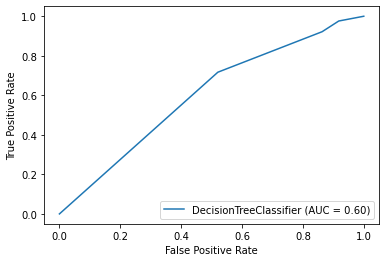

In [50]:
plot_roc_curve(best_tree, X_test, y_test)

In [51]:
#prints all relevant metrics of a model, this will be reused so we're defining it here
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))

In [52]:
print_metrics(y_test, tree_test_preds)

Precision Score: 0.7083333333333334
Recall Score: 0.9216867469879518
Accuracy Score: 0.6820083682008368
F1 Score: 0.8010471204188482


We have an accuracy score of 68% which is certainly higher than the baseline, let's see if we can do better with the Random Forest Classifier next

In [53]:
tree_features = list(zip(best_tree.feature_importances_, X_train.columns.values))
tree_features = sorted(tree_features, key=lambda x: x[0], reverse=True)
tree_features_values = [x[0] for x in tree_features][:4]
tree_features_names = [x[1] for x in tree_features][:4]
tree_features_names

['Followers gained_y',
 'Followers gained_x',
 'Stream time(minutes)_x',
 'Watch time(Minutes)_x']

Text(0, 0.5, 'Feature')

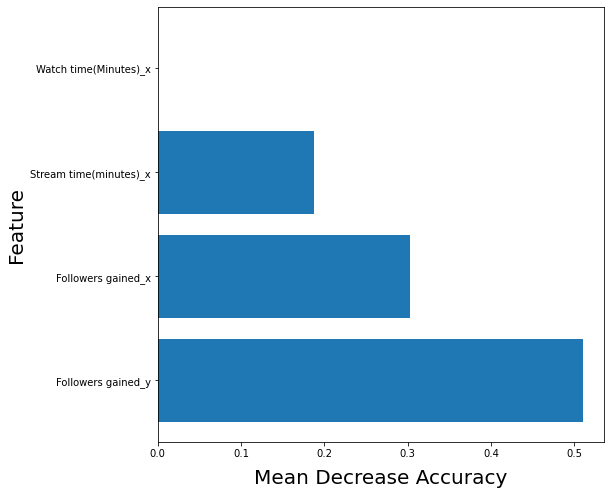

In [54]:
plt.figure(figsize=(8,8))
tree_labels = ['Followers gained_y',
 'Followers gained_x',
 'Stream time(minutes)_x',
 'Watch time(Minutes)_x']
plt.barh(tree_features_names, tree_features_values, align='center', tick_label=tree_labels)
plt.xlabel('Mean Decrease Accuracy', fontsize=20, labelpad=10)
plt.ylabel('Feature', fontsize=20)

Interestingly enough the model loses more accuracy if excluding followers gained rather than views gained meaning that the number of followers that a livestreamer gets is a stronger indication of explosive growth

In [55]:
tree_cv_df = pd.DataFrame(tree_grid_search.cv_results_)
tree_cv_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_leaf_nodes,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.005712,0.005355,0.001723,0.000251,2,4,2,"{'max_depth': 2, 'max_leaf_nodes': 4, 'min_sam...",0.708333,0.708333,0.657343,0.692308,0.692308,0.691725,0.018625,1
1,0.002557,0.000052,0.001536,0.000029,2,4,3,"{'max_depth': 2, 'max_leaf_nodes': 4, 'min_sam...",0.708333,0.708333,0.657343,0.692308,0.692308,0.691725,0.018625,1
2,0.002867,0.000278,0.001219,0.000243,2,4,4,"{'max_depth': 2, 'max_leaf_nodes': 4, 'min_sam...",0.708333,0.708333,0.657343,0.692308,0.692308,0.691725,0.018625,1
3,0.002733,0.000247,0.001316,0.000248,2,5,2,"{'max_depth': 2, 'max_leaf_nodes': 5, 'min_sam...",0.708333,0.708333,0.657343,0.692308,0.692308,0.691725,0.018625,1
4,0.002964,0.000219,0.001227,0.000242,2,5,3,"{'max_depth': 2, 'max_leaf_nodes': 5, 'min_sam...",0.708333,0.708333,0.657343,0.692308,0.692308,0.691725,0.018625,1


## Random Forest

In [56]:
forest = RandomForestClassifier()

In [57]:
# The number of features to consider when looking for the best split
max_features = ['sqrt', 'log2']

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
forrest_grid = {'max_features': max_features,
                'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf
              }

In [58]:
forrest_grid_search = GridSearchCV(estimator=forest, param_grid=forrest_grid, cv=5)

In [59]:
forrest_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]})

Best Parameters

In [60]:
forrest_grid_search.best_params_

{'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 5}

In [61]:
forrest_grid_search.best_score_

0.7210372960372959

Best Predictions

In [62]:
best_forest = forrest_grid_search.best_estimator_

In [63]:
forrest_test_preds = forrest_grid_search.predict(X_test)

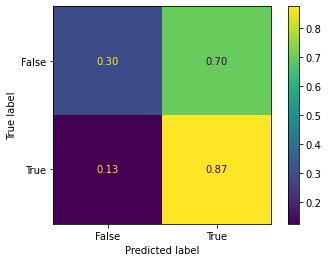

In [64]:
plot_confusion_matrix(best_forest, X_test, y_test, normalize='true', values_format = '.2f')

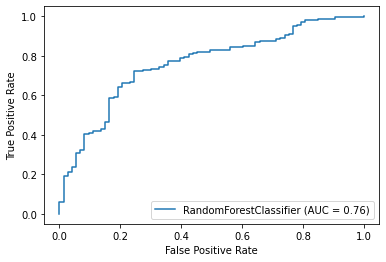

In [65]:
plot_roc_curve(best_forest, X_test, y_test)

In [66]:
print_metrics(y_test, forrest_test_preds)

Precision Score: 0.7397959183673469
Recall Score: 0.8734939759036144
Accuracy Score: 0.698744769874477
F1 Score: 0.8011049723756907


This one has an even higher accuracy score of 72% however we have a lower recall score of 87% it has more false negatives which can be a problem since that'll be missed opportunities to connect with promising streamers. Next we will try Gradient Booster Classifier and see if it performs better.

In [67]:
forrest_features = list(zip(best_forest.feature_importances_, X_train.columns.values))
forrest_features = sorted(forrest_features, key=lambda x: x[0], reverse=True)
forrest_features_values = [x[0] for x in forrest_features][:5]
forrest_features_names = [x[1] for x in forrest_features][:5]

Text(0, 0.5, 'Feature')

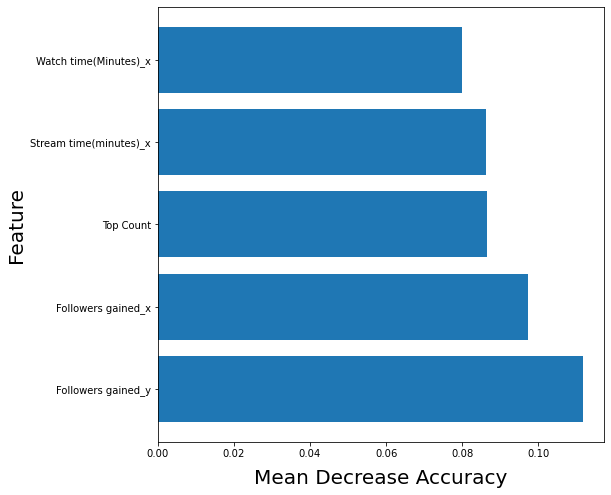

In [68]:
plt.figure(figsize=(8,8))
forrest_labels = ['Followers gained_y',
 'Followers gained_x',
 'Top Count',
 'Stream time(minutes)_x',
 'Watch time(Minutes)_x']

plt.barh(forrest_features_names, forrest_features_values, align='center', tick_label=forrest_labels)
plt.xlabel('Mean Decrease Accuracy', fontsize=20, labelpad=10)
plt.ylabel('Feature', fontsize=20)

There seems to be a trend with mean decrease accuracy where the viewers gained is not that significant of an indicator of explosive growth but rather the number of followers gained.

In [69]:
forest_cv_df = pd.DataFrame(forrest_grid_search.cv_results_)
forest_cv_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.147172,0.007182,0.009059,0.000379,sqrt,1,2,"{'max_features': 'sqrt', 'min_samples_leaf': 1...",0.763889,0.680556,0.685315,0.734266,0.713287,0.715462,0.031083,3
1,0.147181,0.008660,0.009250,0.000198,sqrt,1,5,"{'max_features': 'sqrt', 'min_samples_leaf': 1...",0.750000,0.680556,0.664336,0.699301,0.706294,0.700097,0.028949,16
2,0.142918,0.004414,0.009955,0.001915,sqrt,1,10,"{'max_features': 'sqrt', 'min_samples_leaf': 1...",0.722222,0.666667,0.720280,0.727273,0.699301,0.707148,0.022383,13
3,0.144435,0.005176,0.008915,0.000256,sqrt,2,2,"{'max_features': 'sqrt', 'min_samples_leaf': 2...",0.756944,0.673611,0.727273,0.727273,0.685315,0.714083,0.030498,7
4,0.138412,0.002524,0.008717,0.000205,sqrt,2,5,"{'max_features': 'sqrt', 'min_samples_leaf': 2...",0.756944,0.687500,0.713287,0.699301,0.685315,0.708469,0.026203,12


## Gradient Booster Classifier

In [70]:
gbc = GradientBoostingClassifier(loss = 'exponential',learning_rate=.05,random_state = 42,
                                max_depth=3, max_features='log2', n_estimators = 100)
gbc.fit(X_train,y_train)

GradientBoostingClassifier(learning_rate=0.05, loss='exponential',
                           max_features='log2', random_state=42)

In [71]:
gbc_preds = gbc.predict(X_test)

In [72]:
print_metrics(y_test, gbc_preds)

Precision Score: 0.7681159420289855
Recall Score: 0.9578313253012049
Accuracy Score: 0.7698744769874477
F1 Score: 0.8525469168900804


This is the highest accuracy score yet of 76.9% as well as a recall score of 95.8% It is much better at avoiding false negatives as well as being more accurate overall.
Therefore, we'll make this our final model.

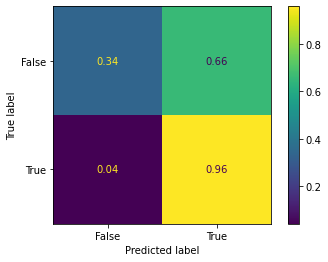

In [73]:
plot_confusion_matrix(gbc, X_test, y_test, normalize='true', values_format = '.2f')

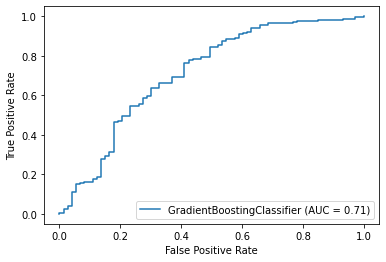

In [74]:
plot_roc_curve(gbc, X_test, y_test)

## Summary and Conclusion

Using the parameters from grid search I created my final optimized models and feature analysis. With this model we are able to accurately predict whether or not a livestreamer will experience rapid explosive growth.

### Policy Recommendations
Use the model to quickly identify promising livestreamers

start off with a small sponsorship to get the livestreamer familiar with your brand and develop that initial relationship with their audience as well

### Further Investigations
The model is incapable of telling just how engaged viewers are. If I was able to get data about how actively engaged viewers are with the content I'd be able to make additional recommendations. If there were metrics such as active watch time, muted stream, and chat time then I could create an additional metric that measured audience engagement which would be incredibly helpful to advertisers.